# Expressivity Analysis: Clustered vs Standard Parameterization for QAOA
#### The main aim of this notebook is to compare the expressivity of the circuit ansätze obtained for the two parametrizations.

* This notebook uses local `vectorized` as the device to run the fidelity computations to estimate the KL-dvergence measure with respect to Haar distribution as a measure of expressivity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('custom')
from openqaoa.qaoa_parameters import PauliOp, Hamiltonian, QAOACircuitParams, create_qaoa_variational_params, QAOAVariationalStandardParams
from openqaoa.problems import Knapsack, MaximumCut, NumberPartition
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.devices import create_device
from openqaoa.qaoalib import dicke_wavefunction, dicke_basis

from openqaoa.optimizers import get_optimizer
from qiskit import QuantumCircuit
from openqaoa.utilities import *
from tqdm import tqdm
from collections import Counter
import pandas as pd

### Problem construction
* randomly initialize (or explicitly specify) a set of numbers to be partitioned
* translate the list of numbers into the QUBO form and extract the cost Hamiltonian from it
* get the exact solution of the problem by calling the `ground_state_hamiltonian` function 
* Initialize the mixer of choice to be used in the QAOA routine

In [2]:
nums=list(np.random.randint(0,200,9))
cost_prob = NumberPartition(nums).get_qubo_problem()
cost_hamil = cost_prob.hamiltonian
n_qubits = cost_hamil.n_qubits

In [3]:
#print the solution to the problem
print(ground_state_hamiltonian(cost_hamil))

(1.0, ['011001010', '100110101'])


In [4]:
mixer_hamil_xy = XY_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'],qubit_connectivity='full')
mixer_hamil_x = X_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'])

### Construct workflow objects
* Create the QAOACircuitParams object -> responsible for the creating the abstract QAOA circuit from cost and mixer Hamiltonians
* Create and initialize the chosen Variational Parameters (for this notebook, we choose to compare Standard vs Clustered params)
* Create the backend object with prepend_states and the chosen device 

In [5]:
p=1
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_x, p=p)

In [6]:
max_std_dev=2
variate_params_clustered = create_qaoa_variational_params(circuit_params,'clustered','ramp',max_std_dev=max_std_dev)
variate_params_standard = create_qaoa_variational_params(circuit_params,'standard','ramp')

In [7]:
# k_excitations = 4
prepend_state = None#dicke_wavefunction(k_excitations,n_qubits = n_qubits)
init_hadamard = True#False

In [8]:
device = create_device('local','vectorized')
backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=init_hadamard)

### Helper functions to compute Expressivity

In [9]:
def compute_fidelity(wf1, wf2):
    """
    Given two wavefunctions wf1, wf2. Compute their fidelities
    """
    overlap1 = np.dot(np.conjugate(wf1),wf2)
    overlap2 = np.dot(np.conjugate(wf2),wf1)
    return np.real(overlap1*overlap2)

def fidelities_random_state_pairs(n_samples, variate_params, backend, seed = 4567):
    """
    Estimate # n_samples fidelity computations between randomly generated pairs of states
    for the variational parameters specified
    """
    np.random.seed(seed)
    fidelities = []
    for i in tqdm(range(n_samples)):
        random_params1 = np.random.uniform(0,2*np.pi,len(variate_params))
        random_params2 = np.random.uniform(0,2*np.pi,len(variate_params))
        
        variate_params.update_from_raw(random_params1)
        random_wf1 = backend.wavefunction(variate_params)
        
        variate_params.update_from_raw(random_params2)
        random_wf2 = backend.wavefunction(variate_params)

        fidelities.append(compute_fidelity(random_wf1,random_wf2))
    
    return fidelities

In [10]:
def haar_uniform_pdf(n_qubits, fid_vector):
    """
    Probability distribution function for Fidelity between two 
    Haar random states generated for n_qubits qubits.
    """
    N = 2**n_qubits #dimension of Hilbert Space
    pdf = [(N-1)*(1-f)**(N-2) for f in fid_vector]
    return pdf

In [72]:
n_samples=2000

In [73]:
fidelity_axis = np.linspace(0,1,n_samples)
haar_pdf = haar_uniform_pdf(9, fidelity_axis)
haar_pdf /= np.linalg.norm(haar_pdf)

In [14]:
fid_std = fidelities_random_state_pairs(n_samples, variate_params_standard, backend_obj)

100%|██████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 199.94it/s]


In [15]:
fid_clustered = fidelities_random_state_pairs(n_samples, variate_params_clustered, backend_obj)

  0%|                                                                      | 0/2000 [00:00<?, ?it/s]/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████████████████████| 2000/2000 [01:28<00:00, 22.72it/s]


In [80]:
fid_probs_std = np.digitize(fid_std,bins=fidelity_axis)
bin_means_std = [fid_std[fid_probs_std == i].mean() for i in range(1, len(fidelity_axis))]
fid_probs_clustered = Counter(np.digitize(fid_clustered, bins = fidelity_axis))
bin_means_clustered = [fid_clustered[fid_probs_clustered == i].mean() for i in range(1, len(fidelity_axis))]

TypeError: only integer scalar arrays can be converted to a scalar index

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1999,) and arg 1 with shape (62,).

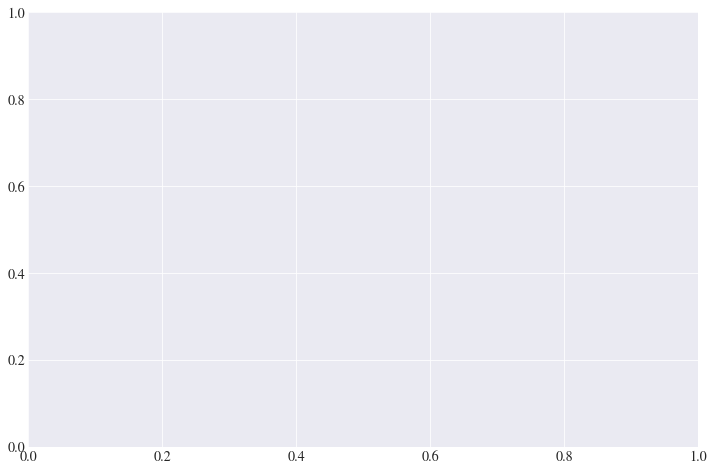

In [78]:
# fig = plt.figure(figsize=(25,5))
plt.bar(bin_means_std,fid_probs_std,width=0.0001)

<BarContainer object of 178 artists>

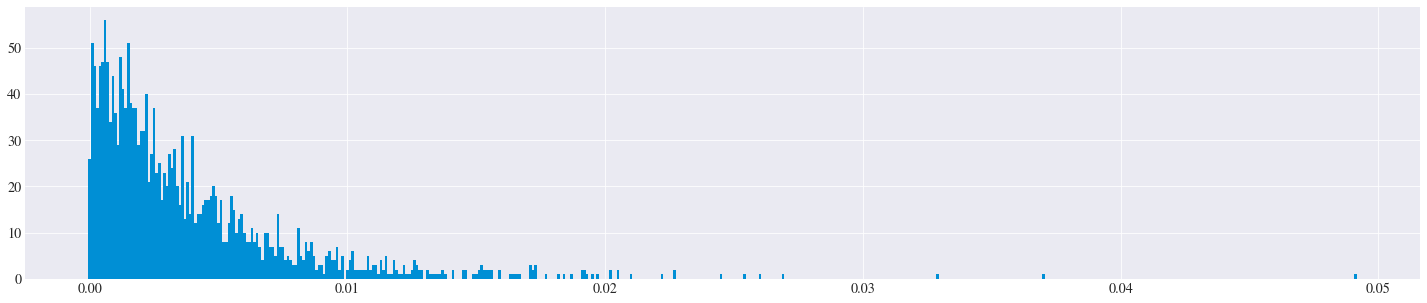

In [165]:
fig = plt.figure(figsize=(25,5))
plt.bar(fid_probs_clustered.keys(), fid_probs_clustered.values(),width=0.0001)

### KL-divergence w.r.t Haar Distribution

In [166]:
from scipy.special import kl_div

In [168]:
kl_div(np.array(list(fid_probs_std.values())),np.array(list(haar_pdf_binned.values())))

ValueError: operands could not be broadcast together with shapes (267,) (59,) 

### Prepare the Optimizer to work with Variational Params and Backend
* specify optimization method and maxiters
* create different optimizer objects for clustered and standard params
* Perform the optimization

In [20]:
optimizer_dict = {'method': 'cobyla', 'maxiter': 2000, 'optimization_progress':True}

In [21]:
optimizer_obj_standard = get_optimizer(backend_obj, variate_params_standard, optimizer_dict)
optimizer_obj_clustered = get_optimizer(backend_obj, variate_params_clustered, optimizer_dict)

In [22]:
optimizer_obj_standard
optimizer_obj_clustered

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 2000

In [23]:
%%time
optimizer_obj_standard()

CPU times: user 191 ms, sys: 11.4 ms, total: 203 ms
Wall time: 207 ms


Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 2000

In [24]:
%%time
optimizer_obj_clustered()

/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 53 s, sys: 275 ms, total: 53.3 s
Wall time: 53.7 s


Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 2000

In [25]:
results_std = optimizer_obj_standard.qaoa_result
results_clustered = optimizer_obj_clustered.qaoa_result

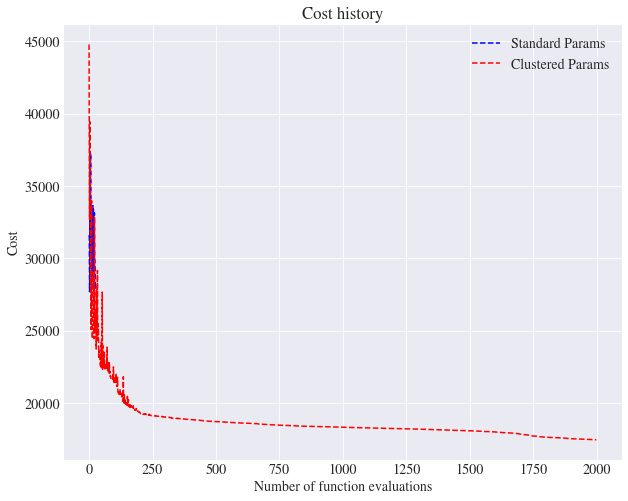

In [26]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
results_std.plot_cost(ax=ax,label='Standard Params')
results_clustered.plot_cost(ax=ax,label='Clustered Params',color='red')

In [36]:
inter_wfs_std = results_std.intermediate['intermediate measurement outcomes']
ent_content_std = [mw_q(wf) for wf in (inter_wfs_std)]

inter_wfs_clustered = results_clustered.intermediate['intermediate measurement outcomes']
ent_content_clustered = [mw_q(wf) for wf in (inter_wfs_clustered)]

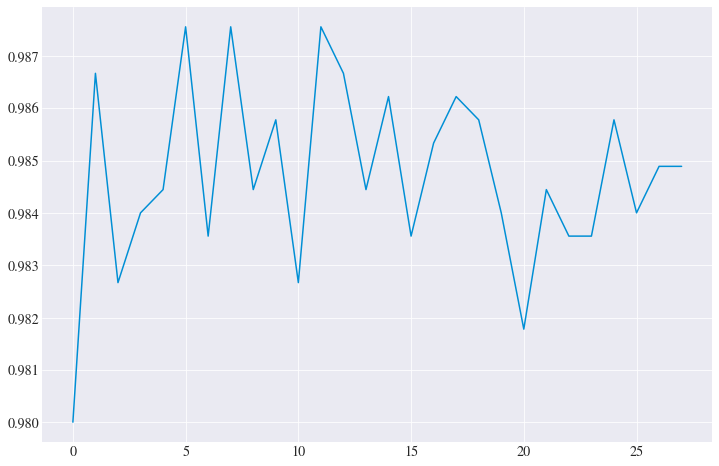

In [49]:
plt.plot(ent_content_std)

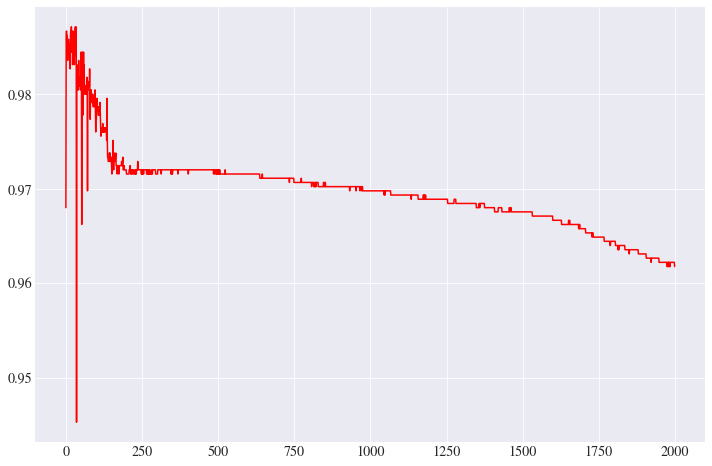

In [50]:
plt.plot(ent_content_clustered,color='red')

In [38]:
opt_wf_std = results_std.optimized['optimized measurement outcomes']
# opt_wf
mw_q(opt_wf_std)

0.9826666666666666

In [39]:
opt_wf_clustered = results_clustered.optimized['optimized measurement outcomes']
# opt_wf
mw_q(opt_wf_clustered)

0.9617777777777778

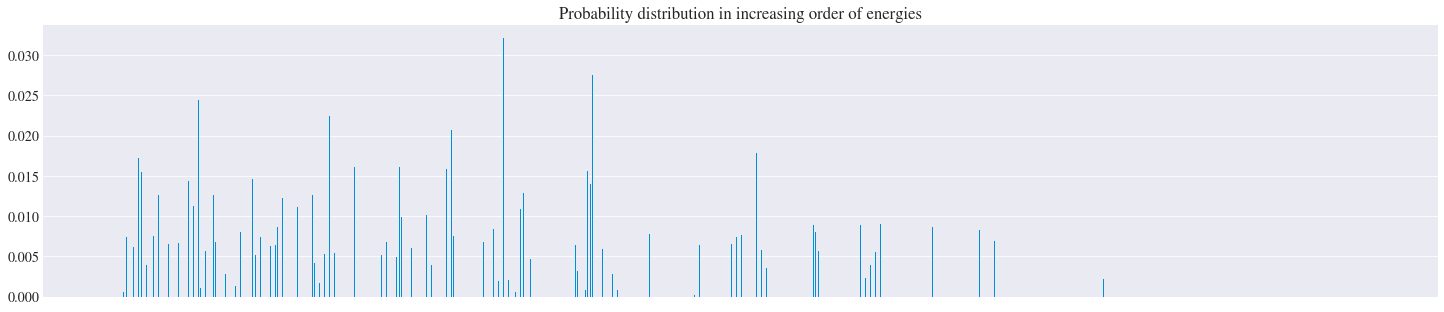

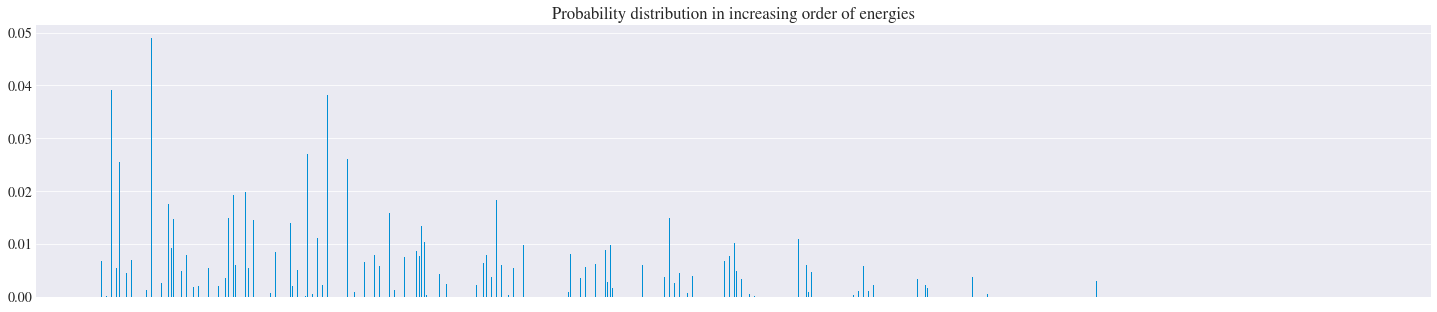

In [61]:
sorted_counts_std = sort_counts_increasing_energy(cost_hamil, results_std.get_counts(opt_wf_std))
sorted_counts_clustered = sort_counts_increasing_energy(cost_hamil,results_clustered.get_counts(opt_wf_clustered))
plot_counts(sorted_counts_std,False)
plot_counts(sorted_counts_clustered,False)

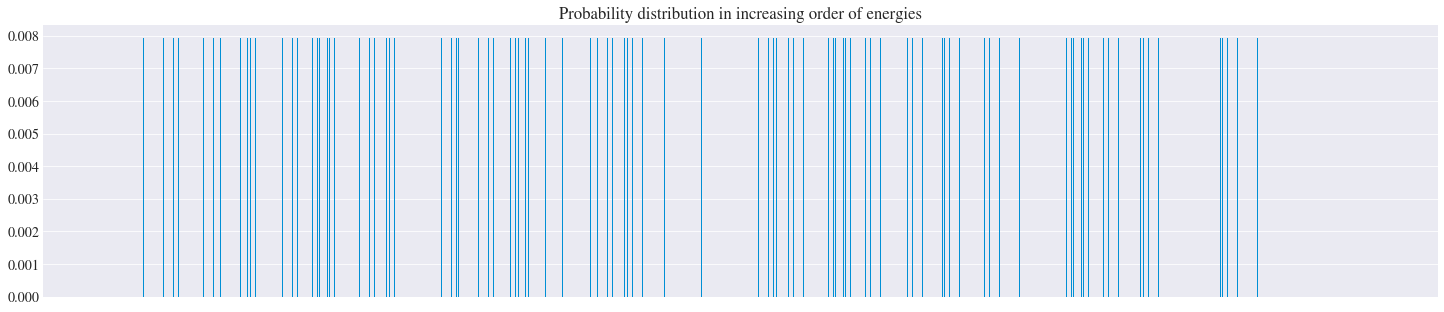

In [57]:
plot_counts(qaoa_probabilities(prepend_state),False)

In [64]:
counts_dict_standard = results_std.get_counts(results_std.optimized['optimized measurement outcomes'])
counts_dict_clustered = results_clustered.get_counts(results_clustered.optimized['optimized measurement outcomes'])

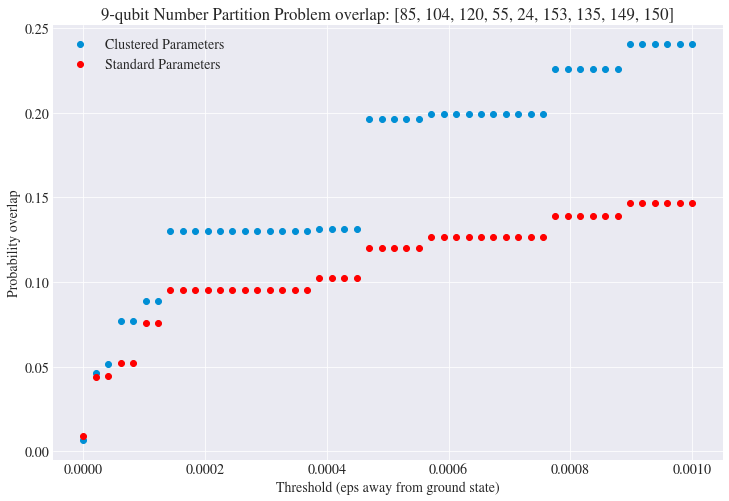

In [66]:
eps = np.linspace(0,0.001,50)
plt.scatter(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered) for ep in eps])
plt.scatter(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_standard) for ep in eps],color='red')
plt.legend(['Clustered Parameters','Standard Parameters'])
plt.xlabel('Threshold (eps away from ground state)')
plt.ylabel('Probability overlap')
plt.title(f'9-qubit Number Partition Problem overlap: {nums}');
# plt.savefig(f'images/9-qubit Number Partition Problem overlap: {nums}.pdf')

### Extract Results from the optimization runs
* Since this notebook compares the Clustered and Standard Parameterizations, extract the results obtained from the two optimization runs for comparison
* Plot cost history, probability overlap with low energy states, probability distribution over basis states

In [26]:
cost_history_clustered = optimizer_obj_clustered.results_information()['cost progress list']

In [27]:
cost_history_standard = optimizer_obj_standard.results_information()['cost progress list']

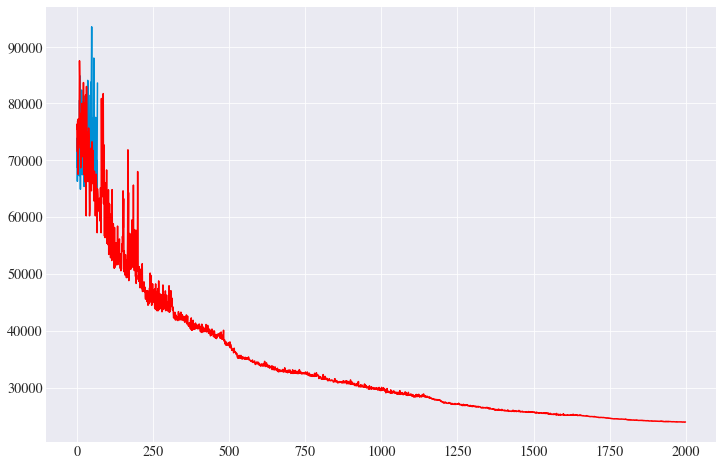

In [29]:
plt.plot(cost_history_standard,label=f'Standard Parameterization, $p={p}$',lw=0.5)
plt.plot(cost_history_clustered, color='red',label=f'Clustered Parameterization (max_std_dev={max_std_dev}), $p={p}$',lw=0.5,alpha=0.7)
# plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost Value')
plt.legend();
plt.title(f'9-qubit Number Partition Problem: {nums}, with NELDER-MEAD for maxiters=2000');
# plt.savefig(f'images/9-qubit Number Partition Problem: {nums}.pdf')

In [30]:
counts_dict_clustered = optimizer_obj_clustered.results_information()['best probability']
counts_dict_standard = optimizer_obj_standard.results_information()['best probability']

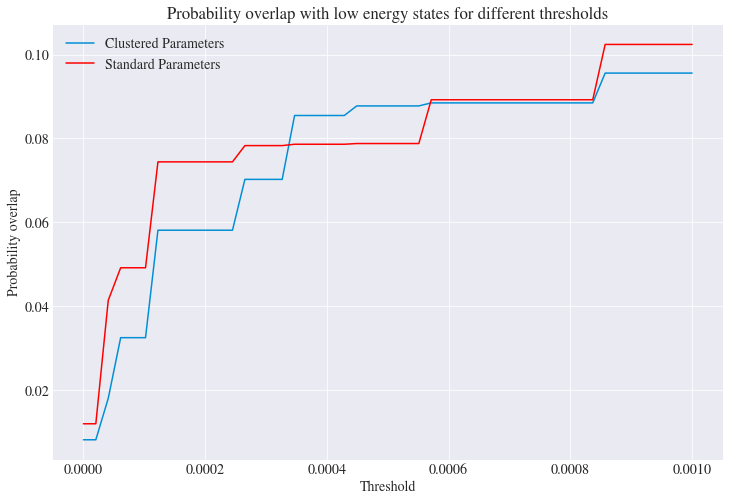

In [32]:
eps = np.linspace(0,0.001,50)
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered) for ep in eps])
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_standard) for ep in eps],color='red')
plt.legend(['Clustered Parameters','Standard Parameters'])
plt.xlabel('Threshold (eps away from ground state)')
plt.ylabel('Probability overlap')
plt.title(f'9-qubit Number Partition Problem overlap: {nums}');
# plt.savefig(f'images/9-qubit Number Partition Problem overlap: {nums}.pdf')

In [33]:
counts_dict_standard_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_standard)
counts_dict_clustered_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_clustered)

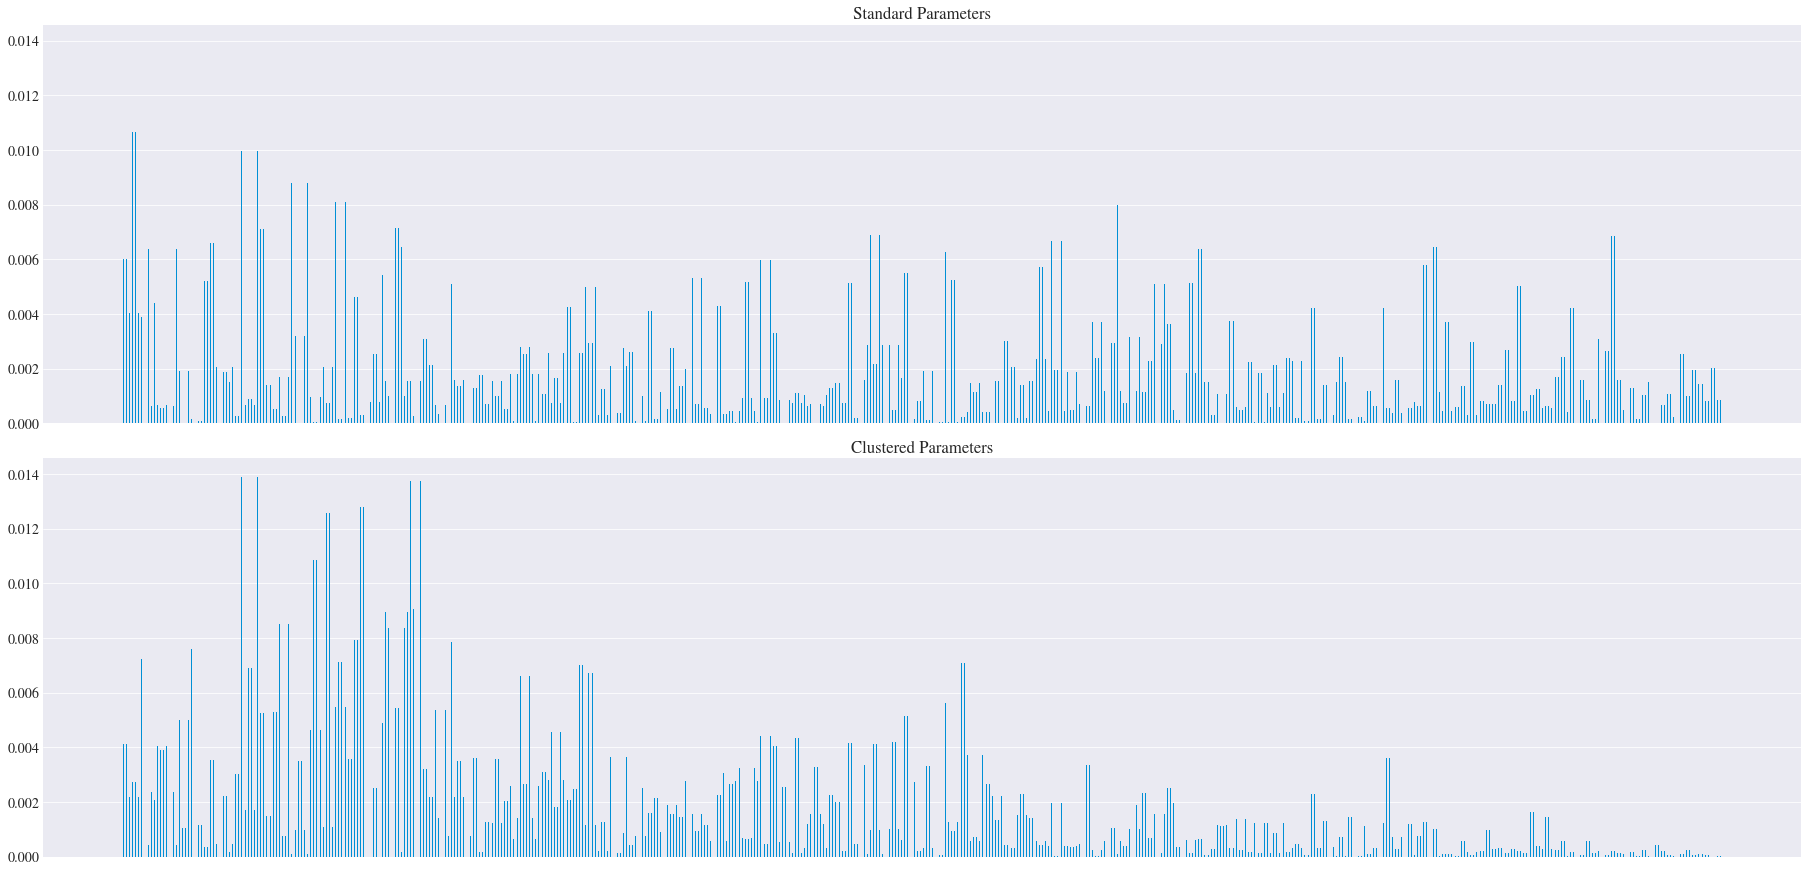

In [35]:
fig,axes = plt.subplots(2,1,figsize=(25,12),constrained_layout=True,sharey=True,sharex=True)
plot_counts(counts_dict_standard_sorted,False,axes[0])
plot_counts(counts_dict_clustered_sorted,False,axes[1])
axes[0].set_title('Standard Parameters')
axes[1].set_title('Clustered Parameters');
plt.suptitle(f'9-qubit Number Partition Problem final distribution: {nums}');
plt.ylim([0,0.09]);
# plt.savefig(f'images/9-qubit Number Partition Problem final energy distribution: {nums}.pdf')